# Building an AskHistorians Comment Classifier

The subreddit r/AskHistorians is a well moderated community where users can ask questions on historical events, and hope to receive well researched, crediable answers. The moderation of this subreddit is time consuming. In this project we hope to gather data, and build a classifier, which can ingest comments, and classify whether they are substansive or not.

## Gathering the data

We built a custom pipeline, where we have built a bot which monitors the r/Askhistorian subreddit for new comments. These are then checked to see if they are top level responses to questions asked, i.e., answers. If so, and are not contained in our SQLite database, they are then stored.

Stored comments are checked (a)periodically to see if they have been removed. If comments are not removed after a certain length of time, we can assume that they are substansive, otherwise, they are not. This process is whereby the moderators of the subreddit handlabel data for use to build the classifier. This database of comments forms this dataset.

## The classifier

In this notebook we hope to capture the essence of certain comments to build a classifier described above. The dataset used to build and train the classifier, will grow daily.

To train the classifier, we have to engage in a fair amount of feature engineering, which requires some domain knowledge. To give you the gist of what is happening, most questions, and answers are wide and varied, but do fall into rough groups. We assume that the correlation between the content (i.e., the words) of the answer and the solution are not the best features to classify the comments (this can/will be investigated further). Rather, from reading numerous responses, and qualitatively inspecting the dataset, we see some patterns revealing themselves, with respect to the metadata of the answers. For example, substansive comments/answers are:

- long
- use long words
- contain many quotes
- contain several reddit and other URLs
- use a lot of bold and italic phrases
- are usually by flaired users or moderators

Unsubstansive comments tend not to follow these trends. Therefore, we hope to distill these patterns into features, described below.

Let us begin.

In [1]:
import numpy as np
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
conn = sqlite3.connect("AskHistoriansComments.db")
df = pd.read_sql_query("select * from Comments;", conn, parse_dates=['CreationTime', 'LastChecked'])
conn.close()

In [3]:
df.head()

,CommentID,Author,CreationTime,CommentText,CommentPerma,Removed,LastChecked
0,dw5nx8r,cnzmur,2018-03-23 12:48:43,Well obviously it would depend on exactly how ...,/r/AskHistorians/comments/86gexs/in_ancient_co...,0,2018-09-11 09:27:54
1,dw5nont,starkimarki,2018-03-23 12:43:30,Henry VII had a great deal to gain by their de...,/r/AskHistorians/comments/86jdla/was_the_backl...,1,2018-04-13 10:03:01
2,dw5n44w,015181510,2018-03-23 12:30:41,"So this has been a while, and I'm going to go ...",/r/AskHistorians/comments/843ubu/why_didnt_the...,0,2018-09-11 09:27:54
3,dw5mo6p,wowbuggertheinfinite,2018-03-23 12:20:20,In order to properly answer your question I wi...,/r/AskHistorians/comments/86gf4f/before_mary_i...,0,2018-09-11 09:27:55
4,dw5mgo0,Bernardito,2018-03-23 12:15:14,"Hi there! Unfortunately, this is not an approp...",/r/AskHistorians/comments/86k4f1/if_you_got_se...,0,2018-09-11 09:27:55


In [4]:
# dropping the rows for which Removed=-1. This sentinel value is for those comments which have not been checked upon
# at least once.
print('Number of total comments in DB: ', len(df.index))
df = df[df['Removed'] != -1]
print('Number of usuable comments in DB: ', len(df.index))

Number of total comments in DB:  2642
Number of usuable comments in DB:  2640


In [5]:
from collections import Counter
c = Counter(df.Removed.tolist())
labels = c.most_common()
print("Removed [0: False, 1: True]")
print(labels)

Removed [0: False, 1: True]
[(0, 2434), (1, 206)]


Text(0.5,0,'Removed [0: False, 1: True]')

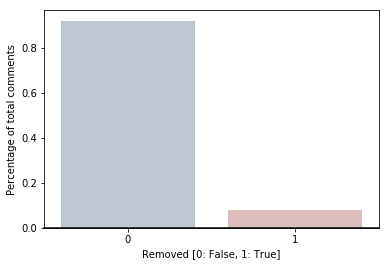

In [6]:
# Center the data to make it diverging
total_comments = float(len(df.index))
x = [val[0] for val in labels]
y = [val[1] / total_comments for val in labels]
ax = sns.barplot(x=x, y=y, palette="vlag")
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("Percentage of total comments")
ax.set_xlabel("Removed [0: False, 1: True]")

Here we see the classic case of an imbalanced dataset. Comments which have not been removed (label 0), are far greater in number than those which have been removed (label 1). To make sure we are accounting for the imbalance, we will use the ROC AUC metric.

To evaluate the classifier we are to build, we first need to create a hold out test set.

In [7]:
# split from training and test set
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df.Removed, random_state=42)

## Feature Engineering of the Metadata
Now that we have the data in the correct form, we can begin to implement our classifier, based on the text's metadata. We have gathered two main types of user from the subreddit: [Moderators](https://old.reddit.com/r/AskHistorians/about/moderators), and [flaired users](https://www.reddit.com/r/AskHistorians/wiki/flairedusers). We assume that comments from the users are less likely to be removed. Therefore, we make a binary variable for each in the data set: mod user, flaired user.


In [8]:
pd.options.mode.chained_assignment = None  # default='warn'

mod_list = list(pd.read_csv('mods.csv')['Mods'].values)
flaired_list = list(pd.read_csv('Flaired.csv')['FlairedUsers'].values)

def is_mod(user_name):
    mod = 0
    if user_name in mod_list:
        mod = 1
    return mod
df_train['IsMod'] = df_train['Author'].apply(lambda x: is_mod(x))
df_test['IsMod'] = df_test['Author'].apply(lambda x: is_mod(x))

def is_flaired(user_name):
    flaired = 0
    if user_name in flaired_list:
        flaired = 1
    return flaired
df_train['IsFlaired'] = df_train['Author'].apply(lambda x: is_flaired(x))
df_test['IsFlaired'] = df_test['Author'].apply(lambda x: is_flaired(x))



Here we apply futher feature engineering to the metadata of the posts, as mentioned in the introduction. These features were gained through domain knowledge, by extensively reading r/AskHistorians, and also qualitatively viewing random samples of each class once they were residing in the database.

In [9]:
from ClassifierUtils import *

# Post Length
df_train['PostLen'] = df_train['CommentText'].apply(lambda x: post_length(x))
df_test['PostLen'] = df_test['CommentText'].apply(lambda x: post_length(x))

# Number of URLs in answer
df_train['UrlNum'] = df_train['CommentText'].apply(lambda x: url_num(x))
df_test['UrlNum'] = df_test['CommentText'].apply(lambda x: url_num(x))

# Number of Reddit URLs in answer
df_train['RedditUrls'] = df_train['CommentText'].apply(lambda x: reddit_urls(x))
df_test['RedditUrls'] = df_test['CommentText'].apply(lambda x: reddit_urls(x))

# Number of new lines
df_train['NewLineNum'] = df_train['CommentText'].apply(lambda x: new_lines(x))
df_test['NewLineNum'] = df_test['CommentText'].apply(lambda x: new_lines(x))

# Average word length
df_train['AveWordLen'] = df_train['CommentText'].apply(lambda x: ave_word_len(x))
df_test['AveWordLen'] = df_test['CommentText'].apply(lambda x: ave_word_len(x))

# Median word length
df_train['MedianWordLen'] = df_train['CommentText'].apply(lambda x: med_word_len(x))
df_test['MedianWordLen'] = df_test['CommentText'].apply(lambda x: med_word_len(x))

# Number of Bold phrases
df_train['BoldPhrases'] = df_train['CommentText'].apply(lambda x: bold_phrases(x))
df_test['BoldPhrases'] = df_test['CommentText'].apply(lambda x: bold_phrases(x))

# Number of italic phrases
df_train['ItalicPhrases'] = df_train['CommentText'].apply(lambda x: italic_phrases(x))
df_test['ItalicPhrases'] = df_test['CommentText'].apply(lambda x: italic_phrases(x))

# Number of quotes
df_train['Quotes'] = df_train['CommentText'].apply(lambda x: quotes(x))
df_test['Quotes'] = df_test['CommentText'].apply(lambda x: quotes(x))

In [10]:
df_train.head(10)

,CommentID,Author,CreationTime,CommentText,CommentPerma,Removed,LastChecked,IsMod,IsFlaired,PostLen,UrlNum,RedditUrls,NewLineNum,AveWordLen,MedianWordLen,BoldPhrases,ItalicPhrases,Quotes
1404,e5auq8e,Commustar,2018-09-03 03:12:43,"If we are talking about the 1880s, I think it ...",/r/AskHistorians/comments/9cc8ft/would_a_briti...,0,2018-09-11 09:32:42,0,1,2419,0,0,17,5.065491,5.0,0,0,0
499,dx9ks78,ghostofherzl,2018-04-12 21:29:48,Part 2:\n\nAll of these factors were part of t...,/r/AskHistorians/comments/8bh0q9/what_was_the_...,0,2018-09-11 09:29:41,0,1,7247,0,0,10,4.961317,4.0,0,8,0
2210,e5poj3x,b1uepenguin,2018-09-10 08:11:40,I’m not sure I quite understand the question. ...,/r/AskHistorians/comments/9ejtl2/wasnt_the_pow...,0,2018-09-12 08:10:47,0,1,1481,0,0,6,5.340517,5.0,0,0,0
1553,e5chk8j,J-Force,2018-09-03 23:27:11,Are we talking about the army of a Crusade (in...,/r/AskHistorians/comments/9cnybq/what_was_the_...,0,2018-09-11 09:33:09,0,0,198,0,0,0,4.378378,4.0,0,0,0
2384,e5tjc1t,AncientHistory,2018-09-12 01:39:26,This is really more of a pre-history question;...,/r/AskHistorians/comments/9f3eiz/when_did_the_...,0,2018-09-13 10:04:46,1,1,94,0,0,0,5.333333,4.0,0,0,0
664,dxakt7g,Abrytan,2018-04-13 11:15:07,"When Adolf Hitler came to power in 1933, one o...",/r/AskHistorians/comments/8bu95w/the_pope_acco...,0,2018-09-11 09:30:13,0,1,6058,3,0,20,5.348739,4.0,0,4,0
2141,e5kz2en,corruptrevolutionary,2018-09-07 22:32:36,What percentage of territory did Germany lose ...,/r/AskHistorians/comments/9d6v1x/short_answers...,0,2018-09-11 09:35:10,0,0,76,0,0,0,4.923077,4.0,0,0,0
1998,e5nqbx6,Tatem1961,2018-09-09 10:55:31,Does anybody know about the naval history of C...,/r/AskHistorians/comments/9e46y3/panel_ama_sai...,0,2018-09-11 09:34:37,0,0,172,0,0,0,5.142857,5.0,0,0,0
1365,e55u47z,GeneralLeeBlount,2018-08-31 15:48:39,Kinda meant to post this yesterday but being b...,/r/AskHistorians/comments/9btw2g/friday_freefo...,0,2018-09-11 09:32:35,0,0,1233,0,0,10,4.680556,4.0,0,0,0
591,dx9suf1,erissays,2018-04-12 23:45:14,"Thank you so much for the votes, everyone! Con...",/r/AskHistorians/comments/8b8wyx/announcing_th...,0,2018-09-11 09:29:58,0,1,82,0,0,0,4.187500,3.0,0,0,0


In [11]:
# Here we select out the metadata features for our classifier to leverage
cols = ['IsMod', 'IsFlaired', 'PostLen', 'UrlNum', 'RedditUrls', 'NewLineNum', 'AveWordLen', 'MedianWordLen', 'BoldPhrases',
        'ItalicPhrases', 'Quotes']
X_train = df_train[cols].values
y_train = df_train['Removed'].values

## Hypertuning and Fitting Various Classifiers

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
import time

def random_tuner(X, y, pipeline, parameters, n_iter_search, clf_output_name, verbose=True):
    """
    Takes in training data along with a pipeline (including a classifier).
    Hypertunes the classifier via random parameter space search, trying n_iter_search
    parameter combinations.
    """
    classifier = RandomizedSearchCV(pipeline, param_distributions=parameters,
                                    n_jobs=-1, cv=5, n_iter=n_iter_search, verbose=1, scoring='roc_auc')
    classifier.fit(X, y)
    if verbose:
        print("Best score: %0.3f" % classifier.best_score_)
        print("Best parameters set:")
        classifier_best_parameters = classifier.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, classifier_best_parameters[param_name]))

    joblib.dump(classifier.best_estimator_, clf_output_name, compress=9)
    print('Classifier saved to: ', clf_output_name)
    return classifier

In [13]:
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline([
        ('clf', LogisticRegression(max_iter=1e4))
    ])

logreg_parameters = {
    'clf__penalty': ('l2', 'l1'),
    'clf__class_weight': (None, 'balanced'),
    'clf__C': (1e-3, 1e-2, 0.1, 1.0, 10.0, 100.0),
    'clf__warm_start': (True, False),
    'clf__fit_intercept': (True, False)
}

n_iter_search = 96

clf_output_name = './LogReg_clf.pkl'
logreg_classifier = random_tuner(X_train , y_train, logreg_pipeline, logreg_parameters, n_iter_search,
               clf_output_name, verbose=True)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best score: 0.782
Best parameters set:
	clf__C: 1.0
	clf__class_weight: None
	clf__fit_intercept: False
	clf__penalty: 'l1'
	clf__warm_start: False
Classifier saved to:  ./LogReg_clf.pkl


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    1.9s finished


In [14]:
X_test = df_train[cols].values
y_test = df_train['Removed'].values

In [15]:
from sklearn.metrics import roc_auc_score

def get_roc_auc(clf, X_test, y_test):
    y_preds = [val[1] for val in clf.predict_proba(X_test)]
    return roc_auc_score(y_test, y_preds)

In [16]:
get_roc_auc(logreg_classifier.best_estimator_, X_test, y_test)

0.793775674882629

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
        ('clf', RandomForestClassifier())
    ])

rf_parameters = {
    'clf__max_depth': [2, 5, 10, None],
    'clf__n_estimators': [10, 20, 100, 150, 200],
    'clf__max_features': [None, 'auto', 'sqrt', 'log2'],
    'clf__class_weight': [None, 'balanced']
}

n_iter_search = 160

clf_output_name = './RandForest_clf.pkl'
rf_classifier = random_tuner(X_train , y_train, rf_pipeline, rf_parameters, n_iter_search,
               clf_output_name, verbose=True)


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.3min finished


Best score: 0.792
Best parameters set:
	clf__class_weight: 'balanced'
	clf__max_depth: 5
	clf__max_features: 'log2'
	clf__n_estimators: 100
Classifier saved to:  ./RandForest_clf.pkl


In [18]:
get_roc_auc(rf_classifier.best_estimator_, X_test, y_test)

0.8570438836724049

In [19]:
from xgboost import XGBClassifier
xg_pipeline = Pipeline([
        ('clf', XGBClassifier())
    ])

xg_parameters = {
    'clf__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5],
    'clf__max_depth': [2, 5, 10],
    'clf__colsample_bytree': [0.25, 0.5, 0.75, 1.0],
    'clf__subsample': [0.25, 0.5, 0.75, 1.0],
    'clf__n_estimators': [10, 20, 100, 150, 200]

}

n_iter_search = 300

clf_output_name = './XGBoost_clf.pkl'
xg_classifier = random_tuner(X_train , y_train, xg_pipeline, xg_parameters, n_iter_search,
               clf_output_name, verbose=True)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1444 tasks      | elapsed:   46.6s


Best score: 0.796
Best parameters set:
	clf__colsample_bytree: 1.0
	clf__learning_rate: 0.2
	clf__max_depth: 2
	clf__n_estimators: 20
	clf__subsample: 0.5
Classifier saved to:  ./XGBoost_clf.pkl


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   49.4s finished


In [20]:
get_roc_auc(xg_classifier.best_estimator_, X_test, y_test)

0.8305192846896192

In [21]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('logreg', logreg_classifier.best_estimator_),
                                    ('rf', rf_classifier.best_estimator_),
                                    ('xgb', xg_classifier.best_estimator_)], voting='soft')
eclf.fit(X_train, y_train)

VotingClassifier(estimators=[('logreg', Pipeline(memory=None,
     steps=[('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=10000.0, multi_class='ovr',
          n_jobs=1, penalty='l1', random_state=None, solver='liblinear',
          tol=0....   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [22]:
get_roc_auc(eclf, X_test, y_test)

0.8379813021648409

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

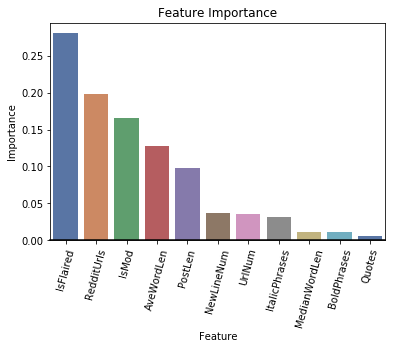

In [23]:
importances = list(rf_classifier.best_estimator_.steps[0][1].feature_importances_)
importance_info = list(zip(cols, importances))

importance_info = sorted(importance_info, reverse=True, key=lambda feature: feature[1])
sorted_cols = [val[0] for val in importance_info]
sorted_importance = [val[1] for val in importance_info]
ax = sns.barplot(x=sorted_cols, y=sorted_importance, palette="deep")
ax.axhline(0, color="k", clip_on=False)
ax.set_title('Feature Importance')
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
plt.xticks(rotation=75)

## Discussion

We have trained a classifier to assess whether a comment will be removed or not, based on it's metadata. Through feature engineering, we have trained 3 diferrent classifiers: Logistic Regression, Random Forest, and XGBoost, via hyperparameter tuning. We have also stacked the models into a Voting Classifier. 

The Random Forest classifier was the most performant with an ROC AUC of 0.857, with the stacked classifier second.

Looking at the feature importances above, we see that if a comment comes from a flaired user, this is likely indicative of  whether or not the comment stays or goes. Flaired users are those which have shown particular apptitude in specific areas of history, such as medievel warfare, or Oceanic region history etc. Interestingly, those that contain Reddit URLs are likely to stay, as these comments are either directing the questioner to similar questions asked previously, or directing them to the rule set for which the subreddit is run upon.

Finally, the next two important features, which are intuitive, are the average word length of the post and the post length. Namely, if you use long words, and your post is long, your answer is likely well thoughtout and therefore kept.


## Future directions
The obvious further directions here are dealing with the class imbalances, and also looking into the correlation between the content and the question.

With respect to the class imbalance, we could delve further into producing sythentic data, to rebalance the classes with SMOTE or Adasyn. This is possible as our data is mostly numeric (for which these techniques rely upon). A popular library for these operations is [Imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/).

As for the content correlation, here we can employ different metrics, based on content similarity, to assess how closely the answer relates to the question, and possibly mark whether or not it is substansive. These measures could come from [word/document embedding](https://radimrehurek.com/gensim/) similarity, or topic similarity from the Latent Dirihlet Allocation algorithm.

## Tricks and Tips

##### Pandas parse dates
When working with SQLite databases, pandas has a convenient feature to convert certain columns that are date-time variables, into such objects in the dataframe. One simply has to add a list of column names to the keyword ```parse_dates``` in the function, as follows:
```python
df = pd.read_sql_query("select * from Comments;", conn, parse_dates=['CreationTime', 'LastChecked'])
```
In our case, we converted epoch time (integer number of seconds since a given time) to date-times.

##### Pulling out feature importances from a pipeline.
When building pipelines and hypertuning, at some point, you would like to access attributes of the classifier. In our case, we had a Random Forest classifier, and wanted to pull out the feature importance of the classifier in the pipeline. A pipeline object is a list of tuples, where the first value is the string name of the object in the second place. You can call on that lists through the ```steps``` attribute, and then find the ```feature_importances_``` from there, as such:
```python
    your_pipeline_classifier.best_estimator_.steps[0][1].feature_importances_
  ```
Note that our classifier/estimator was the first 'step' in our pipeline, hence the 0 index. If, for example you have earlier transformations before your classifier, this number will change (e.g., in the case of doing NLP classification where you use TFID before classifying.

##### Different test scores
Interestingly, after we fitted our pipeline to to ```roc_auc``` metric, when calling the score function on the best estimator:
```python
    your_pipeline_classifier.best_estimator_.score(X_test, y_test)
```
This gives a different value that performing the ```roc_au```c evalution on the predictions after the classifier has made them, which we do with our ```get_roc_auc``` function. This is to do with how the scorer is made via ```RandomSearchCV```. Although all the details are not exactly clear, to be certain, we evalute the ```roc_auc metric``` externally so that we are certain of it's value.
